# Multiple Linear Regression
To demonstrate the usage of the closed-form solution, let’s build a linear regression model for the California housing data set, available from the `sklearn.datasets module`. The goal in this data set is to predict the median house value of a given district (house block) in California, based on 8 different features of that district, such as the median income or the average number of rooms per household.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

np.random.seed(0)

In [3]:
data = fetch_california_housing()
X, y = data.data, data.target
feature_names = data.feature_names

To explore the data set, we merge the features (X) and the labels (y) into a Pandas DataFrame, and display the first rows from the table:

In [4]:
mat = np.column_stack((X, y))
df = pd.DataFrame(mat, columns=np.append(feature_names, 'MedianValue'))
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianValue
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedianValue  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


Luckily, this data set contains only numerical features and has no missing values. Therefore, no data preprocessing is required here (the closed-form solution does not require normalization of the data).

Next, we need to append a column of 1s to the matrix `X_train` in order to represent the intercept terms. This can be easily done with the function `np.column_stack()`:

In [6]:
X_with_bias = np.column_stack((np.ones(len(X)), X))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_with_bias, y, test_size=0.2, random_state=0)

## Closed-Form Solution
Let’s now write a general function to find the optimal $w*$ for any given data set, using the closed-form solution we have found in the theory:

In [9]:
def closed_form_solution(X, y):
    w = np.linalg.inv(X.T @ X) @ X.T @ y
    return w  

In [10]:
w = closed_form_solution(X_train, y_train)
print(w)

[-3.68585691e+01  4.33333407e-01  9.29324337e-03 -9.86433739e-02
  5.93215487e-01 -7.56192502e-06 -4.74516383e-03 -4.21449336e-01
 -4.34166041e-01]


The first component in this vector is the intercept $(w_0)$, and the rest are the coefficients of the eight features in the data set.

Let’s now evaluate the model on the training and the test sets. It is important to evaluate the model on both of them, because a large discrepancy between the training and the test scores may indicate overfitting.

In [14]:
y_train_pred = X_train @ w

train_score = r2_score(y_train, y_train_pred)
print(f'R2 score (train): {train_score:.4f}')

R2 score (train): 0.6089


In [15]:
y_test_pred = X_test @ w

test_score = r2_score(y_test, y_test_pred)
print(f'R2 score (test): {test_score:.4f}')

R2 score (test): 0.5943


## Linear Regression in Scikit-Learn
Scikit-Learn provides a class named LinearRegression that also implements the closed-form solution to the ordinary least squares problem.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [18]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [19]:
print(reg.intercept_)
print(reg.coef_)

-36.858569106801184
[ 4.33333407e-01  9.29324337e-03 -9.86433739e-02  5.93215487e-01
 -7.56192502e-06 -4.74516383e-03 -4.21449336e-01 -4.34166041e-01]


In [20]:
train_score = reg.score(X_train, y_train)
print(f'R2 score (train): {train_score:.4f}')

test_score = reg.score(X_test, y_test)
print(f'R2 score (test): {test_score:.4f}')

R2 score (train): 0.6089
R2 score (test): 0.5943


In [21]:
def plot_residuals(y_train_pred, y_train, y_test_pred, y_test):
    plt.scatter(y_train_pred, y_train_pred - y_train, s=2, marker='o', c='b', label='Training')    
    plt.scatter(y_test_pred, y_test_pred - y_test, s=2, marker='s', c='m', label='Test') 
        
    xmin = min(y_train_pred.min(), y_test_pred.min())
    xmax = max(y_train_pred.max(), y_test_pred.max())
    plt.hlines(y=0, xmin=xmin, xmax=xmax, color='black')    
    
    plt.xlim(xmin, xmax)
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend()

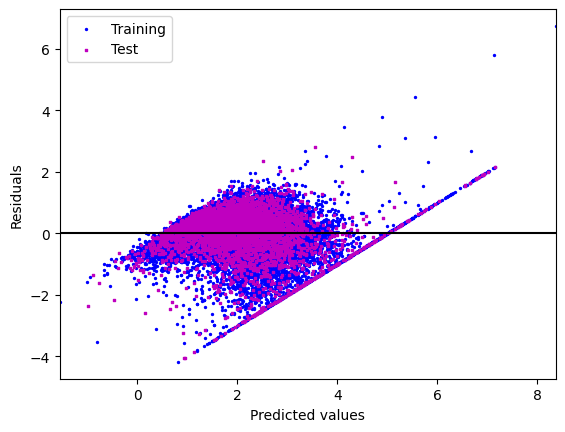

In [22]:
plot_residuals(y_train_pred, y_train, y_test_pred, y_test)

Most of the errors are symmetrically distributed around 0, but there are some outliers on the far ends of the input range, which may require further investigation.

## Gradient Descent
Although the closed-form solution gives us a direct way to find the optimal parameters of the regression model, it suffers from a few drawbacks:

1. The closed-form solution is computationally inefficient when we have a large number of features, since it requires the computation of the inverse of $X^tX$, which is a $m \times m$ matrix ($m$ is the number of features). Computing the inverse of a matrix has a runtime complexity of $O(m^3)$ under most implementations.
2. It requires to have the entire design matrix $X$ in memory, which is not always feasible if we have a very large data set.
3. It does not support online (incremental) learning, since any change to the design matrix $X$ requires re-computation of the inverse of $X^tX$.

Gradient descent is an iterative approach for finding a minimum of a function, where we take small steps in the opposite direction of the gradient in order to get closer to the minimum:

<div style="align: center">
    <img src="media/gradient_descent.png" width="500">
</div>

In order to use gradient descent to find the minimum of the least squares cost, we need to compute the partial derivatives of $J(w)$ with respect to each one of the weights.

$$\frac{\partial J(w)}{\partial w_j} = \frac{\partial}{\partial w_j} \sum_{i=1}^{n} (y_i - h(x_i))^2 \quad \text{(definition of \( J \))}$$

$$= \sum_{i=1}^{n} \frac{\partial}{\partial w_j} (y_i - h(x_i))^2 \quad \text{(sum of derivatives)}$$

$$= \sum_{i=1}^{n} 2(y_i - h(x_i)) \left[ \frac{\partial}{\partial w_j}(y_i - h(x_i)) \right] \quad \text{(chain rule of derivatives)}$$

$$= \sum_{i=1}^{n} 2(y_i - h(x_i)) \left[ \frac{\partial}{\partial w_j} \left( y_i - \sum_{k=0}^{m} w_k x_{ik} \right) \right] \quad \text{(definition of \( h(x) \))}$$

$$= 2 \sum_{i=1}^{n} (y_i - h(x_i)) x_{ij} \quad \text{(partial derivative)}$$

Therefore, the gradient descent update rule is:

$$w_j \leftarrow w_j - \alpha \sum_{i=1}^{n} (h(x_i) - y_i) x_{ij} \quad \text{(The gradient descent update rule)}$$

where $\alpha$ is a learning rate that controls the step size $(0 < \alpha < 1)$. Instead of updating each component of $w$ separately, we can update the entire vector $w$ in one step:

$$w \leftarrow w - \alpha \sum_{i=1}^{n} (h(x_i) - y_i) x_i$$

Gradient descent can be applied in one of the following modes:

1. **Batch gradient descent** — the weights are updated after we compute the error on the entire training set.
2. **Stochastic gradient descent (SGD)** — a gradient descent step is performed after every training example. In this case, the gradient descent update rule takes the following form:

$$w \leftarrow w - \alpha (h(x_i) - y_i) x_i$$

SGD typically converges faster than batch gradient descent as it makes progress after each example, and it also supports online learning since it can process new data points one at a time. On the other hand, SGD is less stable than batch gradient descent, and its convergence to the global optimum is not guaranteed (although in practice it gets very close to the optimum).

<i>Note that whenever you use gradient descent, you must make sure that your data set is normalized (otherwise gradient descent may take steps of different sizes in different directions, which will make it unstable).</i>

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', SGDRegressor())
])

In [24]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('reg', SGDRegressor())])

In [25]:
train_score = pipeline.score(X_train, y_train)
print(f'R2 score (train): {train_score:.4f}')

test_score = pipeline.score(X_test, y_test)
print(f'R2 score (test): {test_score:.4f}')

R2 score (train): -618.6696
R2 score (test): -5732.5083


These are very bad scores! What has just happened?

When you get such bad scores with gradient descent, it usually means that your learning rate is too high, which causes the algorithm to oscillate between the two sides of the minimum:

<div style="align: center">
    <img src="media/bad_scores.png" width="500">
</div>

Let’s reduce the learning rate from $0.01$ to $0.001$ by changing the parameter $eta0$ of the SGDRegressor:

In [26]:
pipeline.set_params(reg__eta0=0.001)

Pipeline(steps=[('scaler', StandardScaler()),
                ('reg', SGDRegressor(eta0=0.001))])

In [27]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('reg', SGDRegressor(eta0=0.001))])

In [28]:
train_score = pipeline.score(X_train, y_train)
print(f'R2 score (train): {train_score:.4f}')

test_score = pipeline.score(X_test, y_test)
print(f'R2 score (test): {test_score:.4f}')

R2 score (train): 0.6025
R2 score (test): 0.5852
